## EE5171 Assignment 2: Log-Mel Spectrogram and MFCC
##### By: Samarth K J (CE22B099)

### Setup

Primarily `numpy` is used for signal generation, `matplotlib` for plotting, and `librosa` for most of the audio processing tasks.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.signal
import IPython.display as ipd

# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)

## Task 1: Signal Generation

A 1-second signal is generated at a 16 kHz sample rate. The signal is a sum of three sinusoids at 400 Hz, 800 Hz, and 1200 Hz.

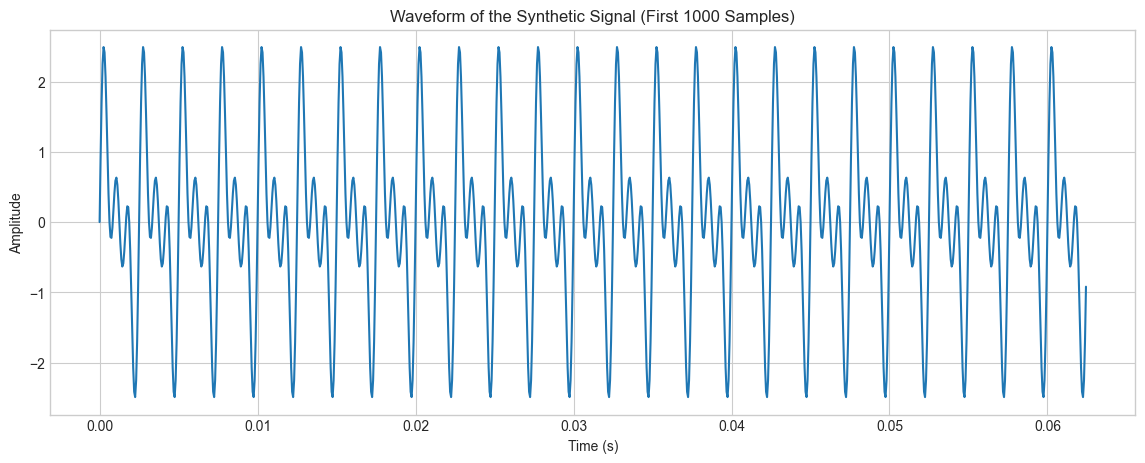

In [3]:
sample_rate = 16000
dur = 1.0 # 1 second
f1, f2, f3 = 400, 800, 1200
A1, A2, A3 = 1.0, 1.0, 1.0 # using same amplitude

# time
t = np.linspace(0.0, dur, int(sample_rate * dur), endpoint=False)

# signal
x = A1 * np.sin(2 * np.pi * f1 * t) + A2 * np.sin(2 * np.pi * f2 * t) + A3 * np.sin(2 * np.pi * f3 * t)

plt.figure(figsize=(14, 5))
plt.plot(t[:1000], x[:1000])
plt.title('Waveform of the Synthetic Signal (First 1000 Samples)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

## Task 2: STFT

Short-Time Fourier Transform (STFT) is computed to observe how the frequency content of the signal changes over time. For our stationary signal, the frequencies should be constant.

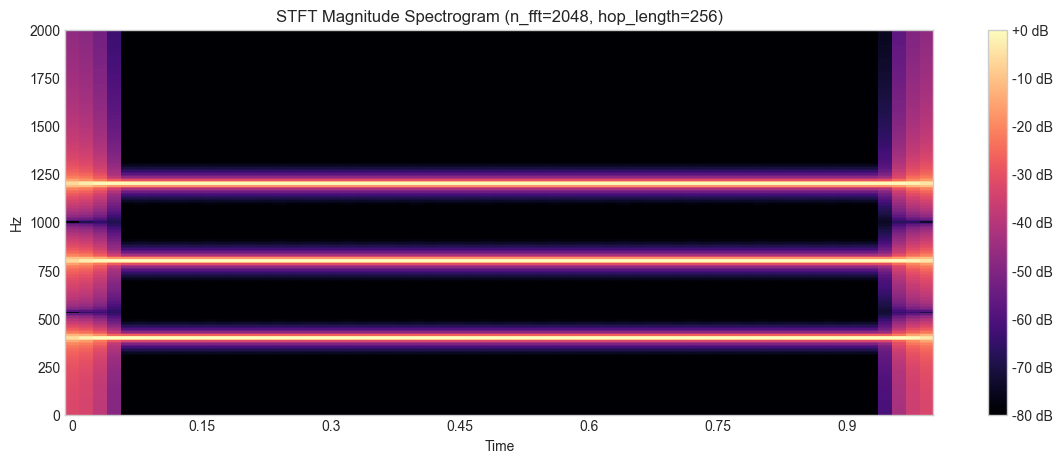

In [4]:
# setting params
n = 2048
hop_len = 256
win = 'hann'
sample_rate = 16000

# stft
S = librosa.stft(x, n_fft=n, hop_length=hop_len, window=win)

# db conversion
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=sample_rate, hop_length=hop_len, x_axis='time', y_axis='linear')
plt.title(f'STFT Magnitude Spectrogram (n_fft={n}, hop_length={hop_len})')
plt.colorbar(format='%+2.0f dB')
plt.ylim(0, 2000) # Zoom in on the relevant frequency range
plt.show()

### Observations

The STFT plot clearly shows three horizontal bands corresponding to the three frequencies (400 Hz, 800 Hz, and 1200 Hz) in the signal. The bands are horizontal because the frequencies are constant over the entire duration of the signal. The color represents the magnitude (energy) at that specific time and frequency bin, with yellow indicating high amplitude/energy.

## Task 3: Log-Mel Spectrogram

The Mel spectrogram is derived from the STFT but uses a frequency scale that is related to human perception (the Mel scale). Lower frequencies are given more resolution than higher frequencies (logarithmically varies wrt. frequency).

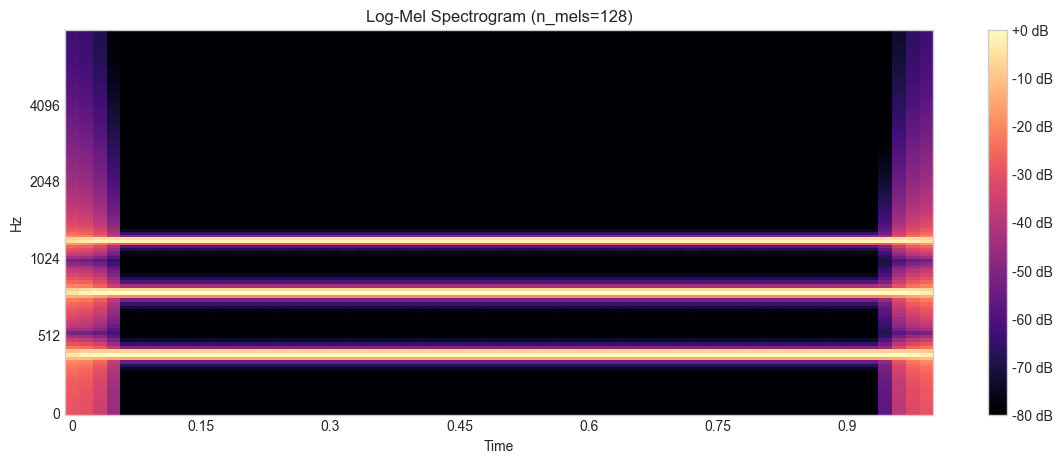

In [5]:
n_mels = 128

# mel spectrogram
M = librosa.feature.melspectrogram(
    y=x, sr=sample_rate, n_fft=n, hop_length=hop_len, n_mels=n_mels
)

# db scale
M_db = librosa.power_to_db(M, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(M_db, sr=sample_rate, hop_length=hop_len, x_axis='time', y_axis='mel')
plt.title(f"Log-Mel Spectrogram (n_mels={n_mels})")
plt.colorbar(format='%+2.0f dB')
plt.show()

### Comparison with STFT

The Y-axis provides a key point of comparison. In the STFT, the frequency scale is linear, so the distance between 400 and 800 Hz is the same as the distance between 800 and 1200 Hz. In the Mel spectrogram, the Y-axis is non-linear. The lower frequencies are spaced further apart, while the higher frequencies are compressed, mimicking human pitch perception.

To better understand this mapping, the Mel filterbank is visualized below.

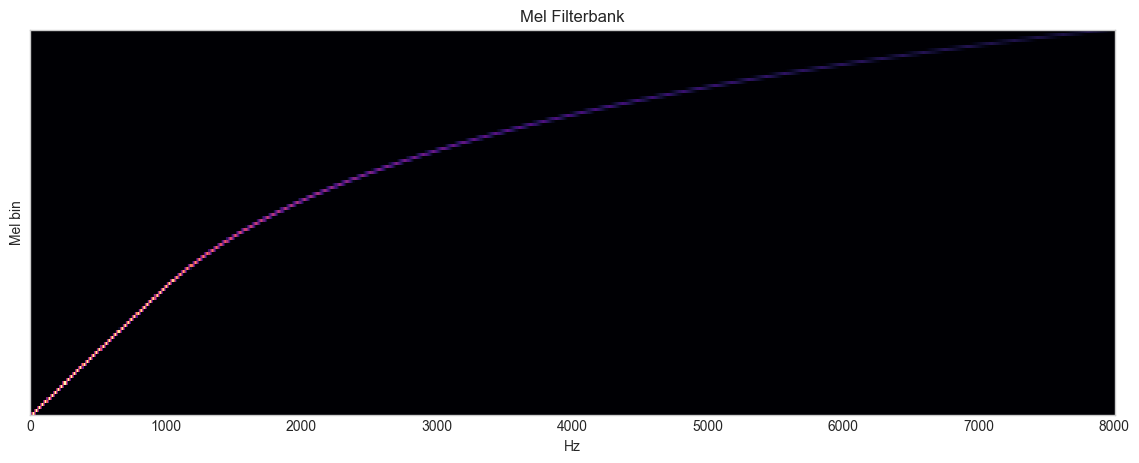

In [6]:
mel_basis = librosa.filters.mel(sr=sample_rate, n_fft=n, n_mels=n_mels)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_basis, x_axis='linear', sr=sample_rate, hop_length=hop_len)
plt.ylabel('Mel bin')
plt.title('Mel Filterbank')
plt.show()

The plot above shows the triangular filters that are applied to the linear STFT spectrum. It can be seen that the filters are wider and more spread out at higher frequencies, and narrower and more densely packed at lower frequencies. This process converts the linear frequency scale to the Mel scale.

## Task 4: MFCCs

Mel-Frequency Cepstral Coefficients (MFCCs) are derived from the log-Mel spectrogram by taking the Discrete Cosine Transform - 2 (DCT). This process de-correlates the filterbank vectors and provides a compact representation of the spectrum.

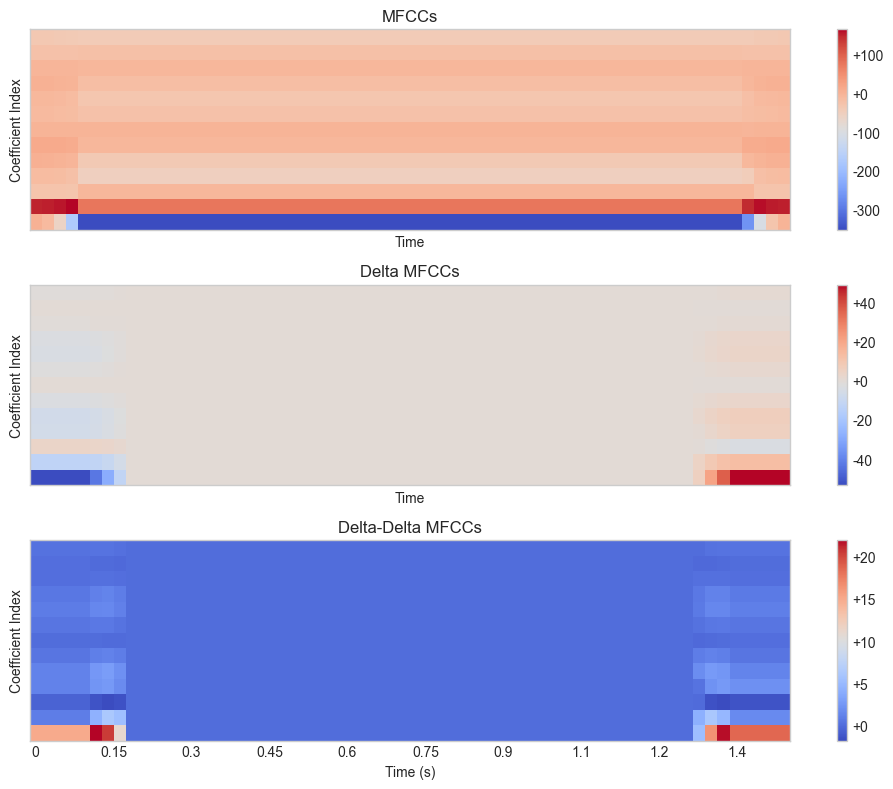

In [7]:
num_mfcc = 13

# mfccs
mfccs = librosa.feature.mfcc(y=x, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n, hop_length=hop_len)

# delta and delta-delta
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))

# --- Plot 1: MFCCs ---
img1 = librosa.display.specshow(mfccs, x_axis="time", ax=ax[0])
ax[0].set_title("MFCCs")
ax[0].set_ylabel("Coefficient Index")
fig.colorbar(
    img1, ax=ax[0], format="%+2.f"
)  # Associate colorbar directly with the axis

# --- Plot 2: Delta MFCCs ---
img2 = librosa.display.specshow(delta_mfccs, x_axis="time", ax=ax[1])
ax[1].set_title("Delta MFCCs")
ax[1].set_ylabel("Coefficient Index")
fig.colorbar(img2, ax=ax[1], format="%+2.f")

# --- Plot 3: Delta-Delta MFCCs ---
img3 = librosa.display.specshow(delta2_mfccs, x_axis="time", ax=ax[2])
ax[2].set_title("Delta-Delta MFCCs")
ax[2].set_ylabel("Coefficient Index")
ax[2].set_xlabel("Time (s)")  # Add x-axis label only to the last plot
fig.colorbar(img3, ax=ax[2], format="%+2.f")

# Use tight_layout to automatically adjust spacing and prevent labels from overlapping
plt.tight_layout()
plt.show()

### Observations

*   **MFCCs**: The MFCC plot shows the MFCC coefficients over time. For our static signal, these coefficients are constant over time (ignoring the boundaries).
*   **Deltas**: The delta features represent the rate of change (delta) of the MFCCs. Since the generated signal is perfectly stationary, the deltas are all close to zero. It is negative at the start of the signal and positive at the end (symmetrically) due to 0 padding at the boundaries.
*   **Delta-Deltas**: These represent the rate of change (delta) of the deltas. They are also close to zero for a stationary signal. Their values are same at the beginning and the end.

## Task 5: Experiments

In this section, we explore how different parameters affect the output representations.

### 5.1 Vary `n_fft`

`n_fft` controls the size of the FFT window. A larger `n_fft` provides better frequency resolution but worse time resolution.

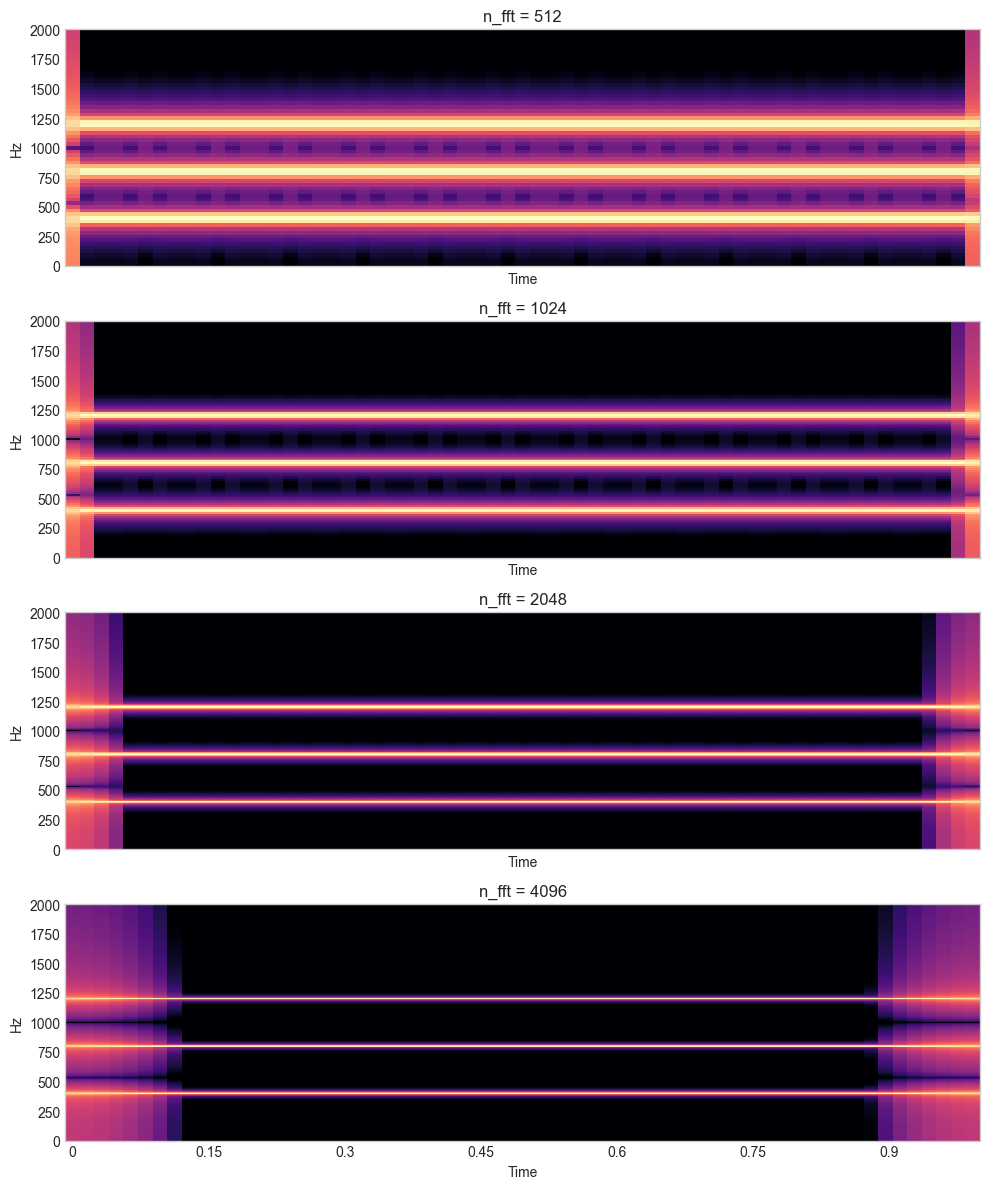

In [8]:
n_fft_values = [512, 1024, 2048, 4096]

fig, ax = plt.subplots(nrows=len(n_fft_values), figsize=(10, 12), sharex=True)

for i, n_fft in enumerate(n_fft_values):
    S_vary = librosa.stft(x, n_fft=n_fft, hop_length=hop_len)
    S_db_vary = librosa.amplitude_to_db(np.abs(S_vary), ref=np.max)
    librosa.display.specshow(S_db_vary, sr=sample_rate, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[i])
    ax[i].set_title(f'n_fft = {n_fft}')
    ax[i].set_ylim(0, 2000)

plt.tight_layout()
plt.show()

#### Observations on `n_fft`

*   **`n_fft = 512`**: The frequency bands are thick and blurry. The frequency resolution is low, meaning it is more difficult to pinpoint the exact frequency of each tone.
*   **`n_fft = 4096`**: The frequency bands are very sharp and well-defined. The frequency resolution is high. However, if there were a fast-changing event in the signal, it would be smeared across time (due to the time-frequency uncertainty principle).

### 5.2 Vary `hop_length`

`hop_length` is the difference (in number of samples) between two successive FFT windows. A smaller `hop_length` gives better time resolution but is computationally more expensive.

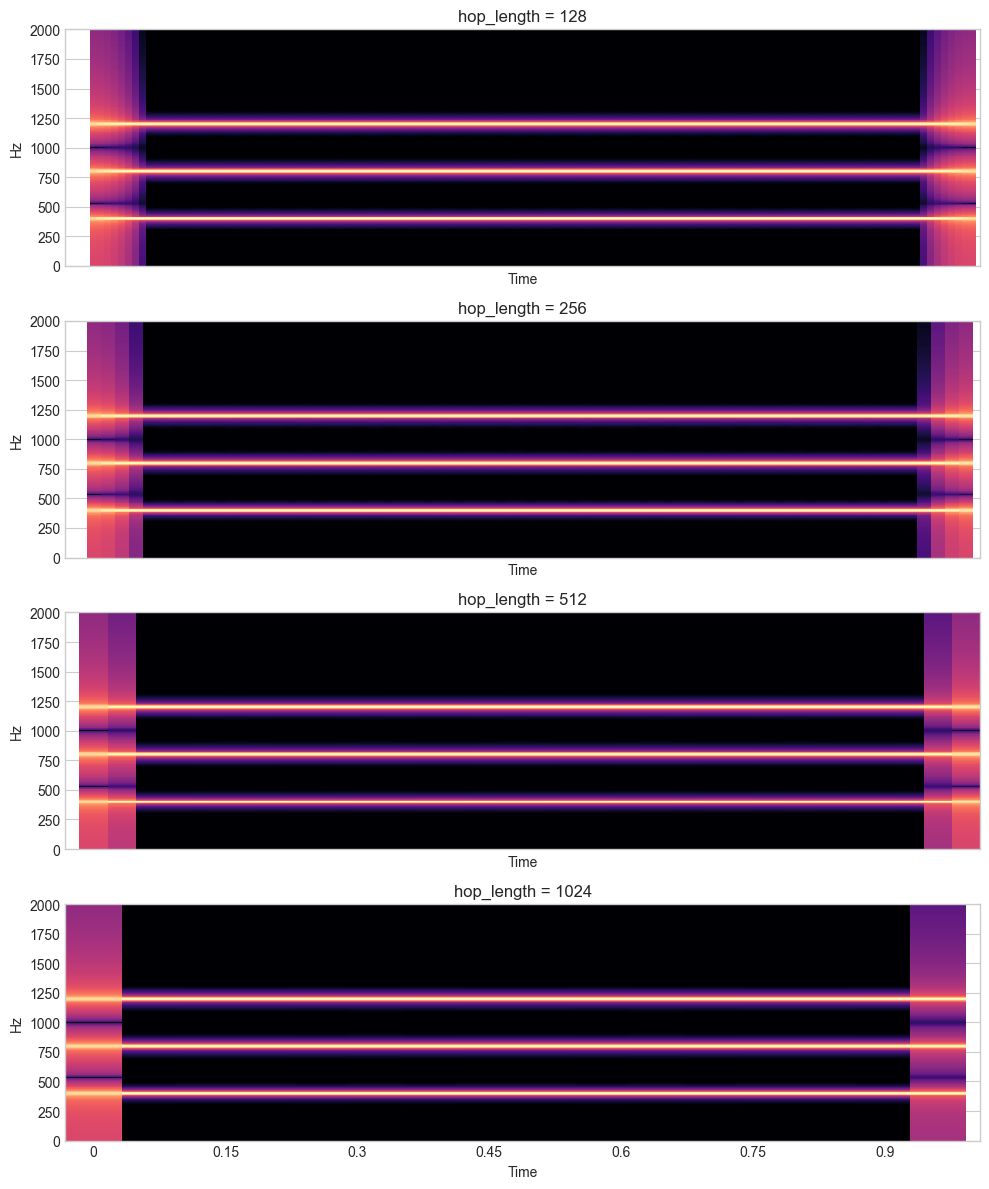

In [9]:
hop_length_values = [128, 256, 512, 1024]

fig, ax = plt.subplots(nrows=len(hop_length_values), figsize=(10, 12), sharex=True)

for i, hop_length in enumerate(hop_length_values):
    S_vary = librosa.stft(x, n_fft=n, hop_length=hop_length)
    S_db_vary = librosa.amplitude_to_db(np.abs(S_vary), ref=np.max)
    librosa.display.specshow(S_db_vary, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='linear', ax=ax[i])
    ax[i].set_title(f'hop_length = {hop_length}')
    ax[i].set_ylim(0, 2000)

plt.tight_layout()
plt.show()

#### Observations on `hop_length`

*   **`hop_length = 128`**: A smaller `hop_length` results in a spectrogram with more columns (time frames), providing higher resolution along the time axis. If the signal's frequency were to change rapidly, this setting would capture the change effectively.
*   **`hop_length = 1024`**: The spectrogram is very coarse in time, with very few time frames, resulting in poor time resolution. The overlap between windows is small, and events occurring between frames might be missed.

### 5.3 Vary `n_mels`

`n_mels` is the number of Mel filters to use. It controls the resolution of the Mel spectrogram along the frequency axis. It also gives us the size of the mel filter bank vector.

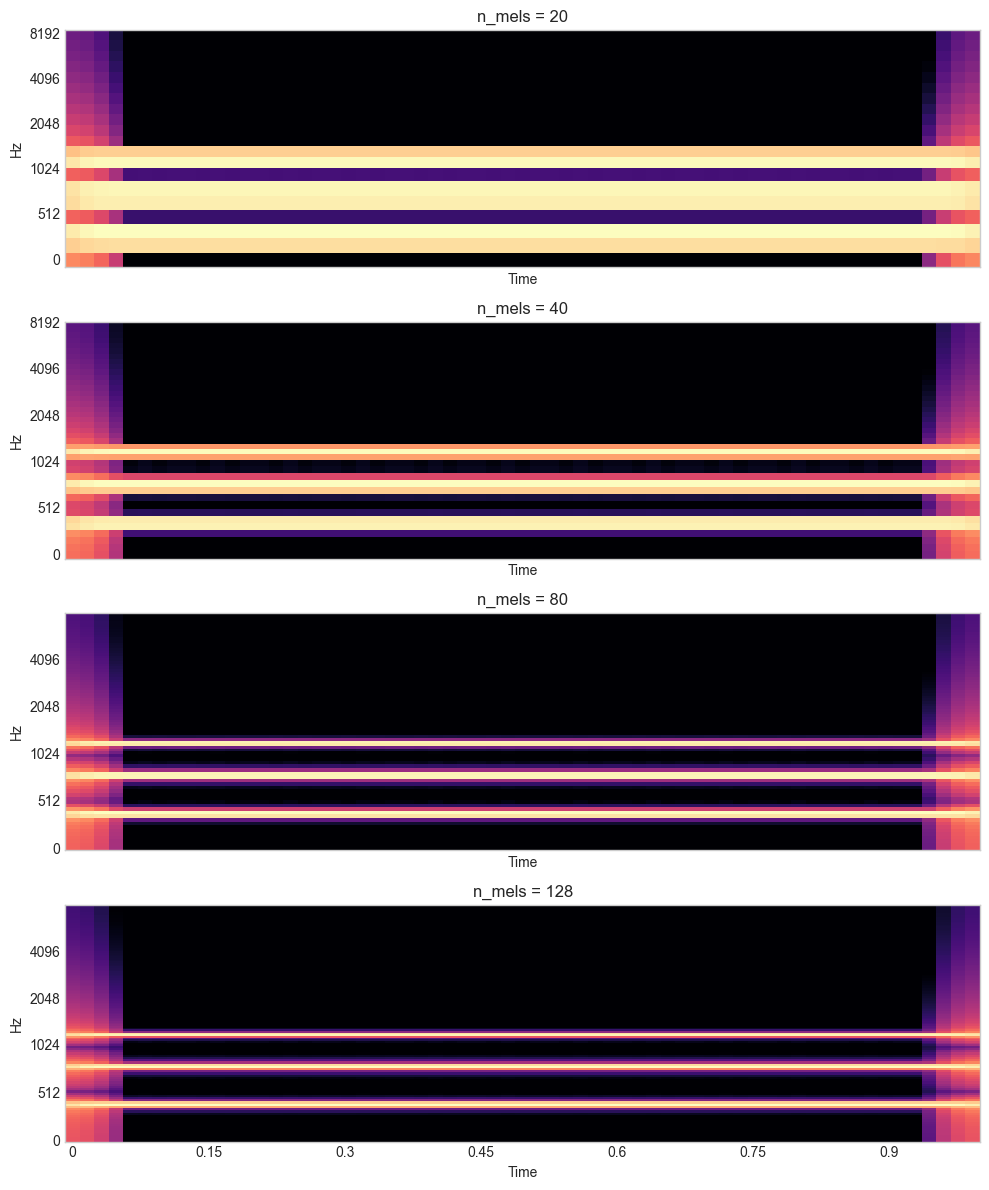

In [10]:
n_mels_values = [20, 40, 80, 128]

fig, ax = plt.subplots(nrows=len(n_mels_values), figsize=(10, 12), sharex=True)

for i, n_mels in enumerate(n_mels_values):
    M_vary = librosa.feature.melspectrogram(y=x, sr=sample_rate, n_fft=n, hop_length=hop_len, n_mels=n_mels)
    M_db_vary = librosa.power_to_db(M_vary, ref=np.max)
    librosa.display.specshow(M_db_vary, sr=sample_rate, hop_length=hop_len, x_axis='time', y_axis='mel', ax=ax[i])
    ax[i].set_title(f'n_mels = {n_mels}')

plt.tight_layout()
plt.show()

#### Observations on `n_mels`

*   **`n_mels = 20`**: The frequency resolution is very coarse. The three distinct tones are still somewhat visible but are much thicker and less defined. If the tones were more closely spaced, they might merge into a single band.
*   **`n_mels = 128`**: The frequency resolution is high, and the three tones are clearly separated. This provides a more detailed representation of the spectrum on the Mel scale.

We use size 80 generally, in this course.

### 5.4 Vary number of MFCCs

We vary `n_mfcc` to observe which coefficients capture the broad spectral shape versus fine details.

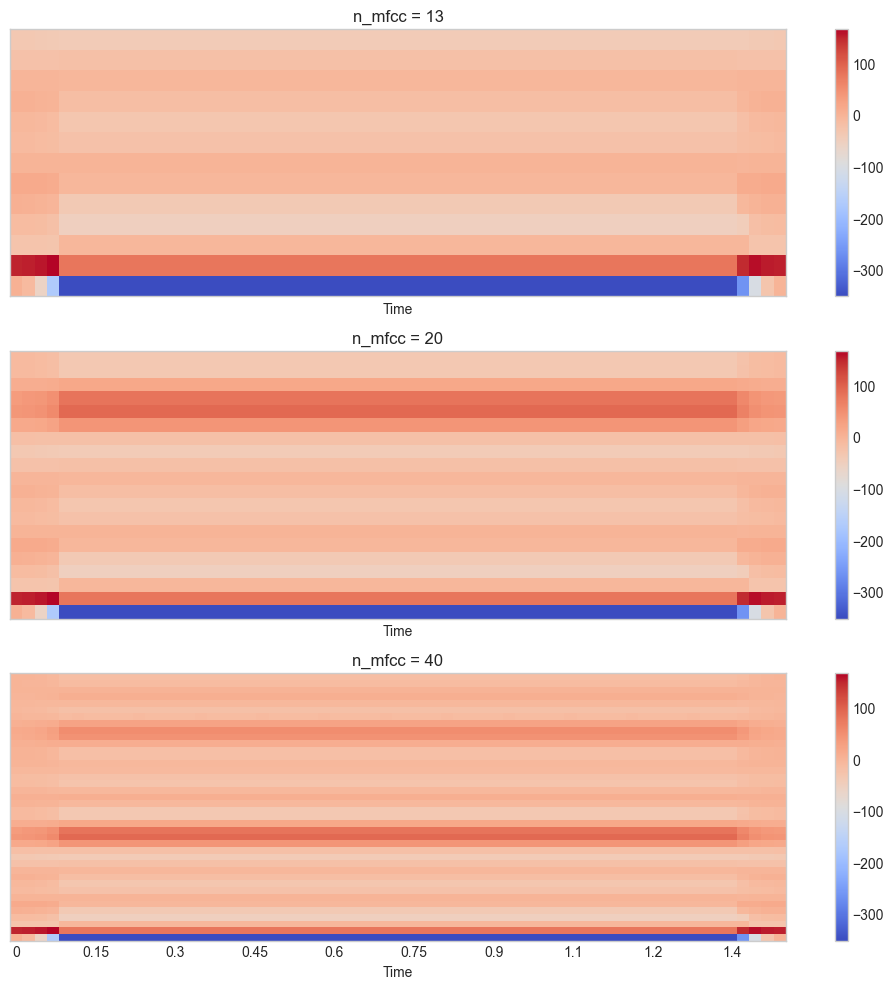

In [11]:
n_mfcc_values = [13, 20, 40]

fig, ax = plt.subplots(nrows=len(n_mfcc_values), figsize=(10, 10), sharex=True)

for i, n_mfcc in enumerate(n_mfcc_values):
    mfccs_vary = librosa.feature.mfcc(
        y=x, sr=sample_rate, n_mfcc=n_mfcc, n_fft=n, hop_length=hop_len
    )
    img = librosa.display.specshow(mfccs_vary, x_axis='time', ax=ax[i])
    ax[i].set_title(f'n_mfcc = {n_mfcc}')
    fig.colorbar(img, ax=ax[i])

plt.tight_layout()
plt.show()

#### Observations on `n_mfcc`

*   As `n_mfcc` increases, we include higher-order coefficients. For a simple signal like this, these higher coefficients have very small values. In complex signals such as speech, these coefficients capture finer textural details of the spectrum. 
*   For most speech recognition tasks, 13-20 MFCCs are sufficient because they capture the essential shape of the vocal tract, which is a key factor in distinguishing different phonemes.

We generally use 13 MFCCs (before delta and delta-delta) in this course.

### 5.5 Apply pre-emphasis

Pre-emphasis is a filter applied to boost the energy in high frequencies. This is a common preprocessing step in speech processing because high-frequency content often has lower magnitude.

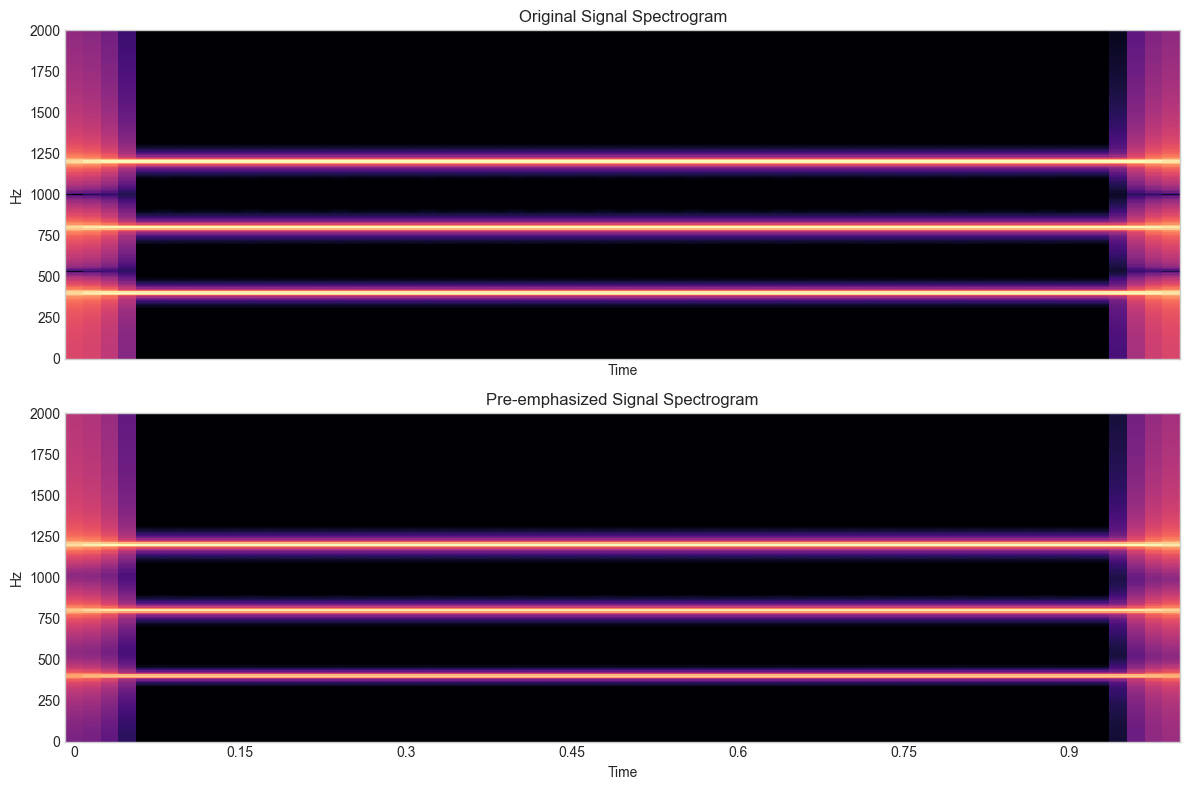

In [12]:
# pre-emphasis
x_pre = librosa.effects.preemphasis(x, coef=0.97)

# stft
S_original_db = librosa.amplitude_to_db(np.abs(librosa.stft(x, n_fft=n, hop_length=hop_len)), ref=np.max)
S_pre_db = librosa.amplitude_to_db(np.abs(librosa.stft(x_pre, n_fft=n, hop_length=hop_len)), ref=np.max)

fig, ax = plt.subplots(nrows=2, figsize=(12, 8), sharex=True, sharey=True)

librosa.display.specshow(S_original_db, sr=sample_rate, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[0])
ax[0].set_title('Original Signal Spectrogram')
ax[0].set_ylim(0, 2000)

librosa.display.specshow(S_pre_db, sr=sample_rate, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[1])
ax[1].set_title('Pre-emphasized Signal Spectrogram')

plt.tight_layout()
plt.show()

#### Observations on Pre-emphasis

- Comparing the two plots confirms that pre-emphasis acts as a high-pass filter. In the original spectrogram, all three tones have equal intensity. After pre-emphasis, the magnitudes are amplified proportionally to their frequency: the 1200 Hz tone is the most intense, followed by 800 Hz, while the 400 Hz tone has the lowest relative intensity.

- In the context of natural speech, where low frequencies (like those in vowels) naturally have much more energy than high frequencies (like in consonants), this process helps to balance the spectrum. By boosting the weaker high-frequency components, it prevents the powerful low-frequency components from dominating subsequent analysis and ensures that important phonetic details are not lost.

### Task 5.6: Experiments with Closely Spaced Tones

In this section, we repeat the first five experiments from Task 5 using a new signal with two closely spaced frequencies. This is designed to highlight the challenges and trade-offs in time-frequency analysis when components are not well-separated.

We will generate a new signal with frequencies at **800 Hz**, **880 Hz**, and **1500 Hz**.

In [13]:
# frequencies
f1_close, f2_close, f3_close = 800, 880, 1500

x_close = A1 * np.sin(2 * np.pi * f1_close * t) + A2 * np.sin(2 * np.pi * f2_close * t) + A3 * np.sin(2 * np.pi * f3_close * t)

### 5.1 Vary `n_fft` (Frequency Resolution)

We begin by repeating the `n_fft` experiment. This is the most critical test for resolving closely spaced frequencies.

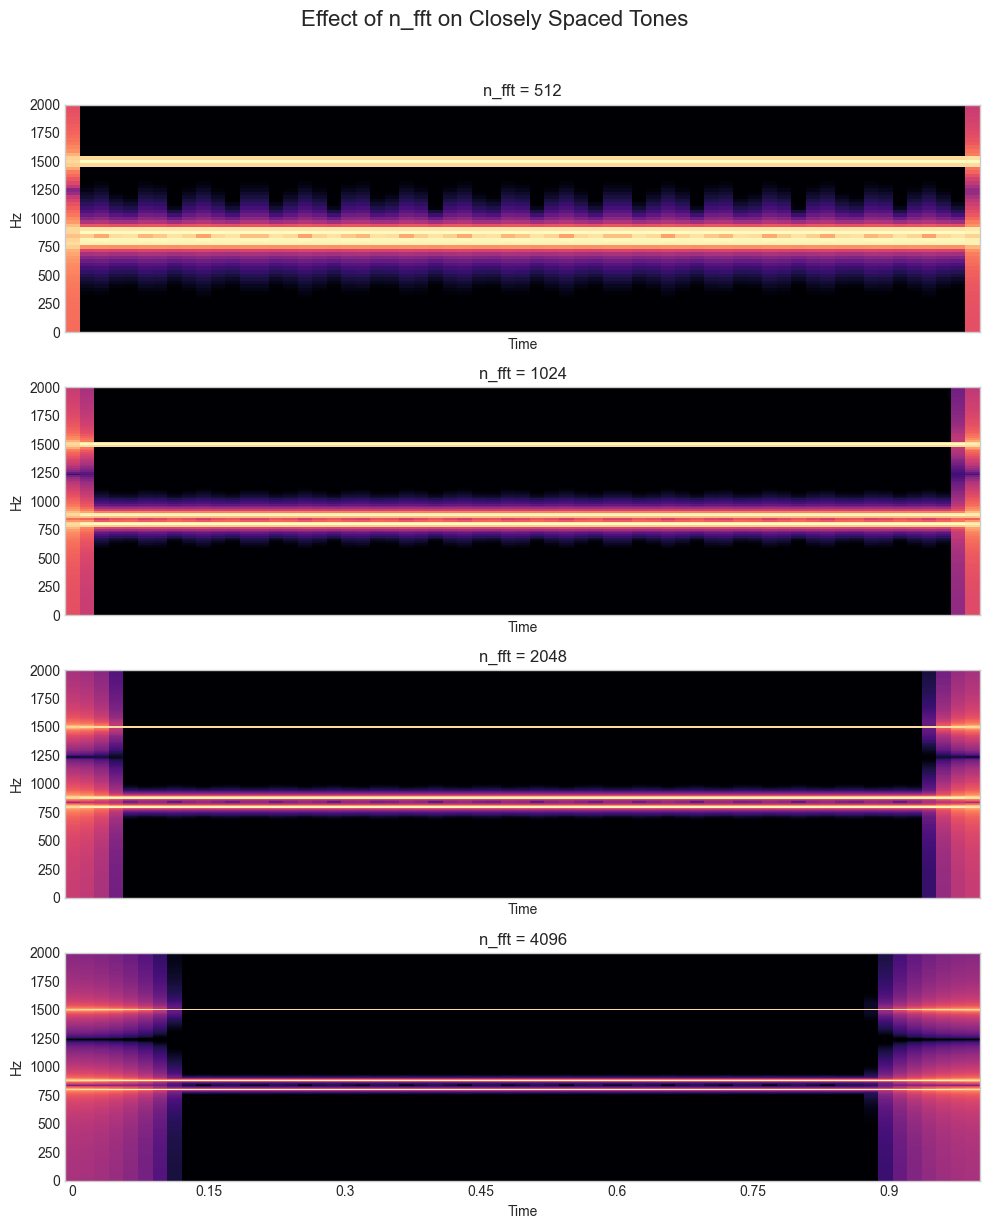

In [14]:
n_fft_values = [512, 1024, 2048, 4096]
hop_len = 256

fig, ax = plt.subplots(nrows=len(n_fft_values), figsize=(10, 12), sharex=True)
fig.suptitle('Effect of n_fft on Closely Spaced Tones', fontsize=16, y=1.02)

for i, n_fft in enumerate(n_fft_values):
    S_vary_close = librosa.stft(x_close, n_fft=n_fft, hop_length=hop_len)
    S_db_vary_close = librosa.amplitude_to_db(np.abs(S_vary_close), ref=np.max)
    librosa.display.specshow(S_db_vary_close, sr=sample_rate, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[i])
    ax[i].set_title(f'n_fft = {n_fft}')
    ax[i].set_ylim(0, 2000)

plt.tight_layout()
plt.show()

#### Observations
*   **`n_fft = 512`**: The frequency resolution is insufficient. The 800 Hz and 880 Hz tones are merged into a single, thick band. It is hard to tell that two distinct tones are present.

*   **`n_fft = 1024`**: The tones at 800 Hz and 880 Hz begin to resolve into two distinct lines, although they are still close and blurred.

*   **`n_fft = 2048 and 4096`**: With a very large FFT window, the frequency resolution is excellent. The two tones are now clearly separated and appear as sharp, distinct horizontal lines.

*   **Conclusion**: This experiment demonstrates that a large `n_fft` is essential to resolve frequencies that are close to each other.

### 5.2 Vary `hop_length` (Time Resolution)

Next, we investigate the effect of `hop_length` on the stationary signal. We use a fixed `n_fft=2048`.

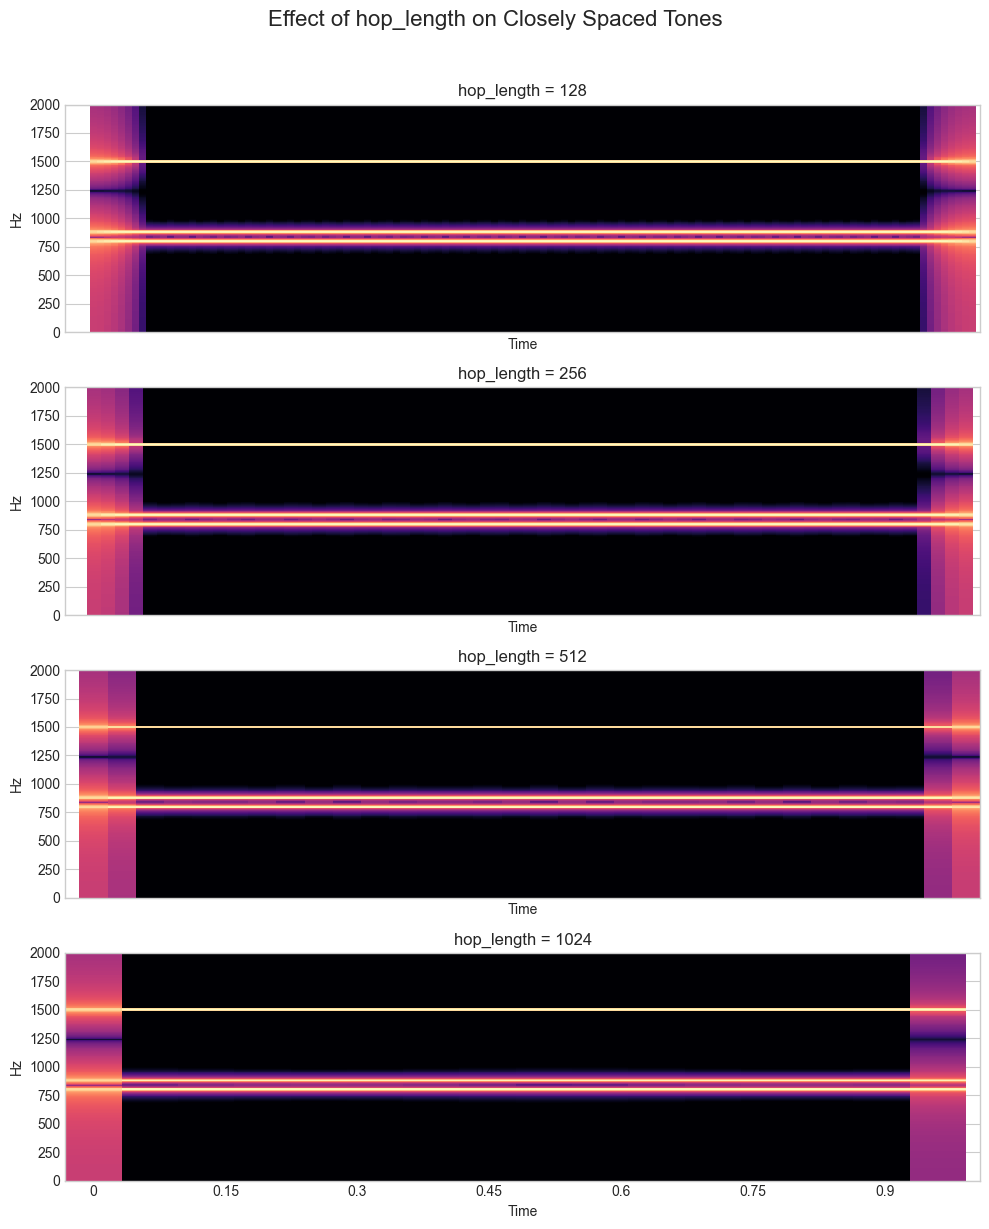

In [15]:
hop_length_values = [128, 256, 512, 1024]
n_fft_fixed = 2048

fig, ax = plt.subplots(nrows=len(hop_length_values), figsize=(10, 12), sharex=True)
fig.suptitle('Effect of hop_length on Closely Spaced Tones', fontsize=16, y=1.02)

for i, hop_length in enumerate(hop_length_values):
    S_vary = librosa.stft(x_close, n_fft=n_fft_fixed, hop_length=hop_length)
    S_db_vary = librosa.amplitude_to_db(np.abs(S_vary), ref=np.max)
    librosa.display.specshow(S_db_vary, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='linear', ax=ax[i])
    ax[i].set_title(f'hop_length = {hop_length}')
    ax[i].set_ylim(0, 2000)

plt.tight_layout()
plt.show()

#### Observations
*   The primary effect of varying `hop_length` is on the time axis. A smaller `hop_length` results in a spectrogram with more time frames (pixels), providing higher time resolution.

*   Because our signal is stationary, varying the time resolution does not change our interpretation of the signal's content. The frequency bands remain horizontal and at the same location.

*   **Conclusion**: For a stationary signal, `hop_length` mainly affects the computational cost.

### 5.3 Vary `n_mels` (Mel-Scale Resolution)

We now examine how the number of Mel filters affects the representation of our closely spaced tones.

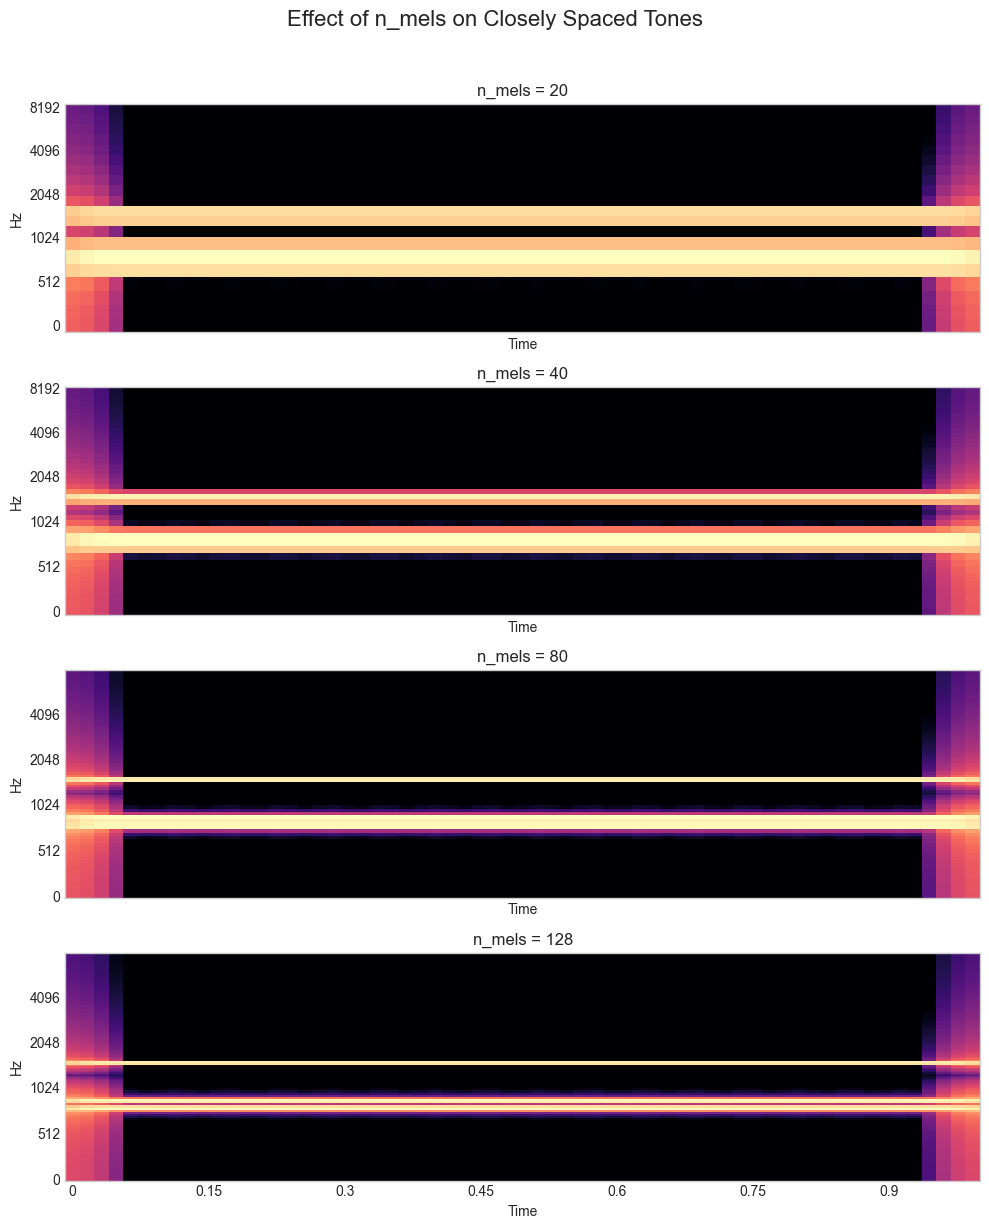

In [16]:
n_mels_values = [20, 40, 80, 128]

fig, ax = plt.subplots(nrows=len(n_mels_values), figsize=(10, 12), sharex=True)
fig.suptitle('Effect of n_mels on Closely Spaced Tones', fontsize=16, y=1.02)

for i, n_mels in enumerate(n_mels_values):
    M_vary = librosa.feature.melspectrogram(y=x_close, sr=sample_rate, n_fft=2048, hop_length=256, n_mels=n_mels)
    M_db_vary = librosa.power_to_db(M_vary, ref=np.max)
    librosa.display.specshow(M_db_vary, sr=sample_rate, hop_length=256, x_axis='time', y_axis='mel', ax=ax[i])
    ax[i].set_title(f'n_mels = {n_mels}')

plt.tight_layout()
plt.show()

#### Observations
*   **`n_mels = 20, 40, 80`**: The Mel-scale resolution is extremely low. The 800 and 880 Hz tones are completely merged into one thick band. The 1500 Hz tone is also very coarse.
At `n_mels=80` the resolution is somewhat better.

*   **`n_mels = 128`**: As the number of Mel filters increases, the resolution on the Mel-frequency axis improves. At these higher values, we can begin to see two distinct, albeit close, bands for the 800 and 880 Hz tones.

*   **Conclusion**: Even with an adequate `n_fft`, a low number of Mel filters will merge closely spaced frequencies. A higher `n_mels` is required to preserve the spectral detail from the STFT in the Mel-spectrogram.

### 5.4 Vary Number of MFCCs

We check if the new spectral shape from the closely spaced tones is reflected in the MFCCs.

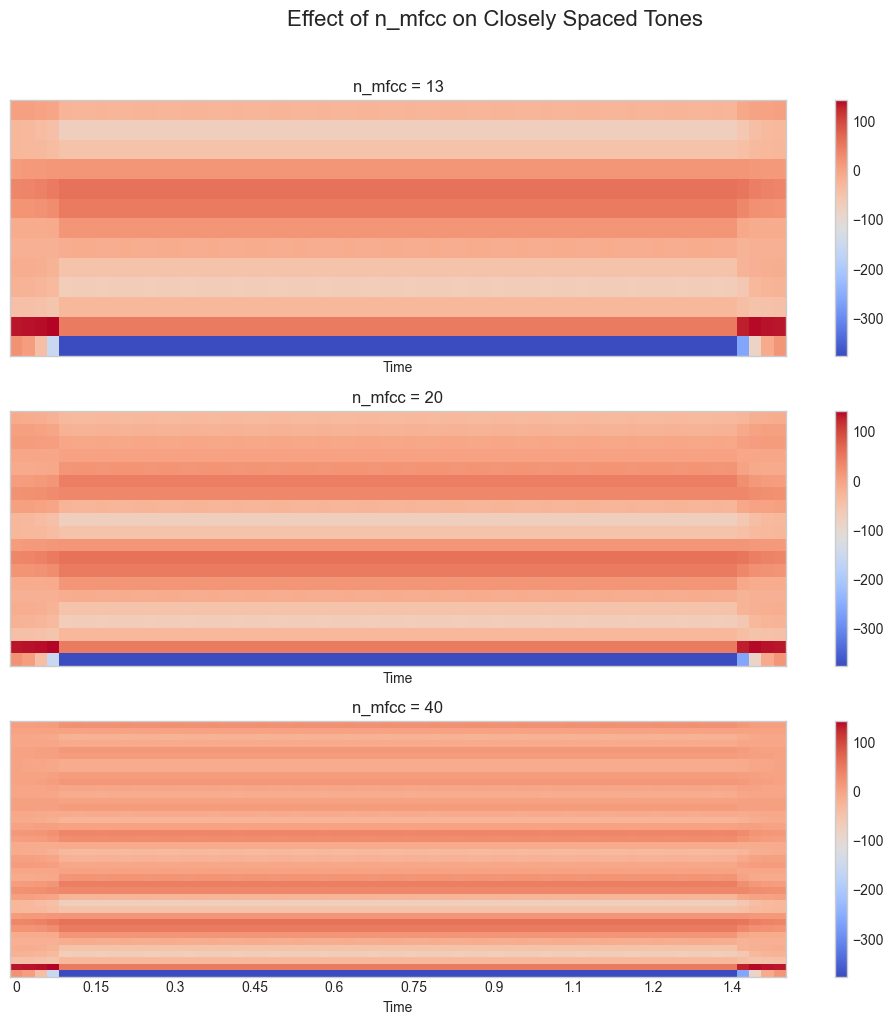

In [17]:
n_mfcc_values = [13, 20, 40]

fig, ax = plt.subplots(nrows=len(n_mfcc_values), figsize=(10, 10), sharex=True)
fig.suptitle('Effect of n_mfcc on Closely Spaced Tones', fontsize=16, y=1.02)

for i, n_mfcc in enumerate(n_mfcc_values):
    mfccs_vary = librosa.feature.mfcc(y=x_close, sr=sample_rate, n_mfcc=n_mfcc, n_fft=2048, hop_length=256)
    img = librosa.display.specshow(mfccs_vary, x_axis='time', ax=ax[i])
    ax[i].set_title(f'n_mfcc = {n_mfcc}')
    fig.colorbar(img, ax=ax[i])

plt.tight_layout()
plt.show()

#### Observations
*   As with the first signal, the MFCCs for this stationary signal are constant over time (except for the boundary effects). 

*   **Conclusion**: The lower-order MFCCs (top rows) effectively capture the new broad spectral shape. The higher-order coefficients remain small, as the signal is still composed of simple, sharp sinusoids and lacks complex spectral texture.

### 5.5 Apply Pre-emphasis

Finally, we apply pre-emphasis to see how it affects the closely spaced tones and the higher frequency component.

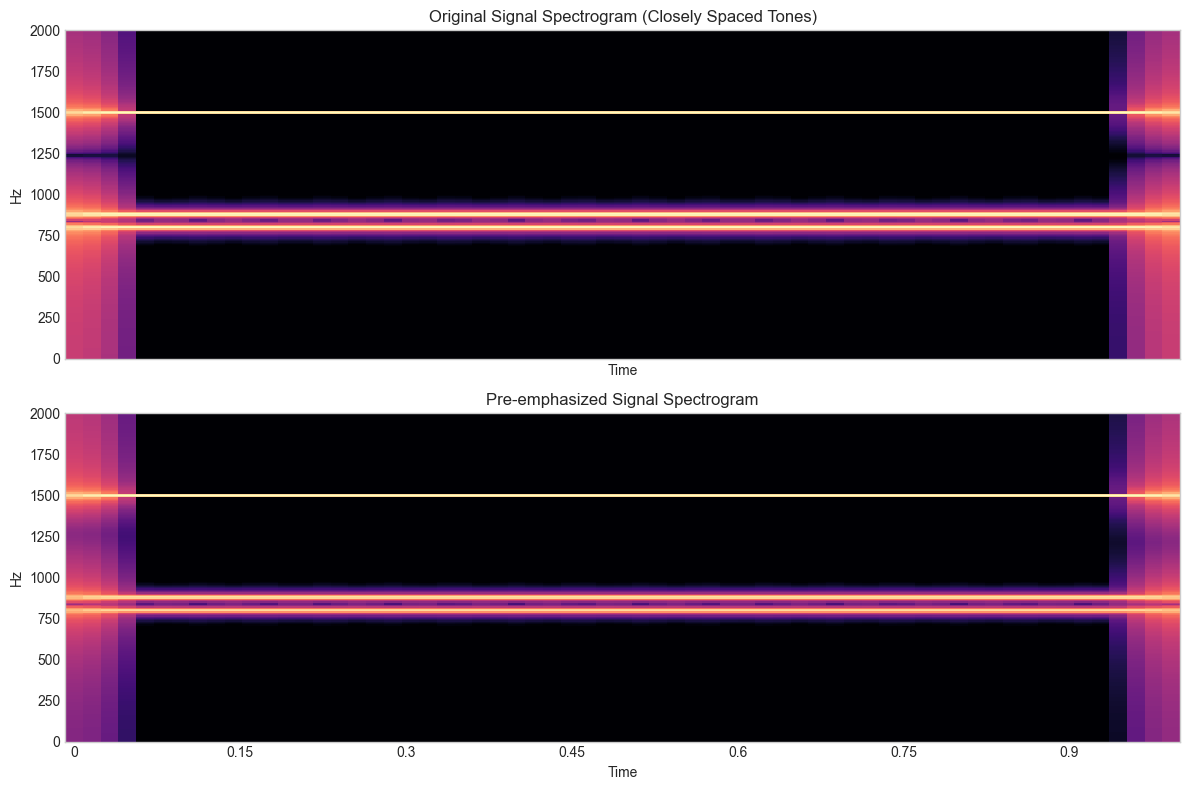

In [18]:
x_close_pre = librosa.effects.preemphasis(x_close, coef=0.97)

# stft
S_close_db = librosa.amplitude_to_db(np.abs(librosa.stft(x_close, n_fft=2048, hop_length=256)), ref=np.max)
S_close_pre_db = librosa.amplitude_to_db(np.abs(librosa.stft(x_close_pre, n_fft=2048, hop_length=256)), ref=np.max)

fig, ax = plt.subplots(nrows=2, figsize=(12, 8), sharex=True, sharey=True)

librosa.display.specshow(
    S_close_db, sr=sample_rate, hop_length=256, x_axis="time", y_axis="linear", ax=ax[0]
)
ax[0].set_title('Original Signal Spectrogram (Closely Spaced Tones)')
ax[0].set_ylim(0, 2000)

librosa.display.specshow(
    S_close_pre_db,
    sr=sample_rate,
    hop_length=256,
    x_axis="time",
    y_axis="linear",
    ax=ax[1],
)
ax[1].set_title('Pre-emphasized Signal Spectrogram')

plt.tight_layout()
plt.show()

#### Observations
*   The effect of the high-pass pre-emphasis filter is somewhat visible. 

*   **Conclusion**: Pre-emphasis consistently amplifies higher frequencies relative to lower ones, regardless of their spacing. This reinforces its role in balancing spectral tilt, which is especially important for signals like speech where energy is naturally higher at lower frequencies.

## Task 5.7: Vowels Dataset

The same analysis is now applied to real speech signals. We will first download a few vowel sounds from the [North Texas Vowel Database](https://personal.utdallas.edu/~assmann/KIDVOW1/North_Texas_vowel_database.html). 

We will analyze the vowel 'iy' (as in 'heed') from an adult male, an adult female, a 7-year old child, a 5-year old child and a 3-year old child speaker.

In [ ]:
import librosa
files = {
    "male": "../data/vowels/iy/kabrii01.wav",
    "female": "../data/vowels/iy/kaccii01.wav",
    "7_yo": "../data/vowels/iy/k7bsii01.wav",
    "5_yo": "../data/vowels/iy/k5atii03.wav",
    "3_yo": "../data/vowels/iy/k3ajii02.wav",
}

# load data
audio_data = {}
for key, path in files.items():
    y, sr_orig = librosa.load(path, sr=None) # Load with original sr to hear it
    print(f"{key} Speaker ('ae' vowel):")
    display(ipd.Audio(y, rate=sr_orig))
    audio_data[key] = librosa.resample(y, orig_sr=sr_orig, target_sr=sample_rate)

male Speaker ('ae' vowel):


female Speaker ('ae' vowel):


7_yo Speaker ('ae' vowel):


5_yo Speaker ('ae' vowel):


3_yo Speaker ('ae' vowel):


### 5.7.1: Varying `n_fft` Across Speakers

We examine the time-frequency trade-off by varying `n_fft`. A small `n_fft` gives good time resolution (capturing formants), while a large `n_fft` gives good frequency resolution (capturing harmonics).

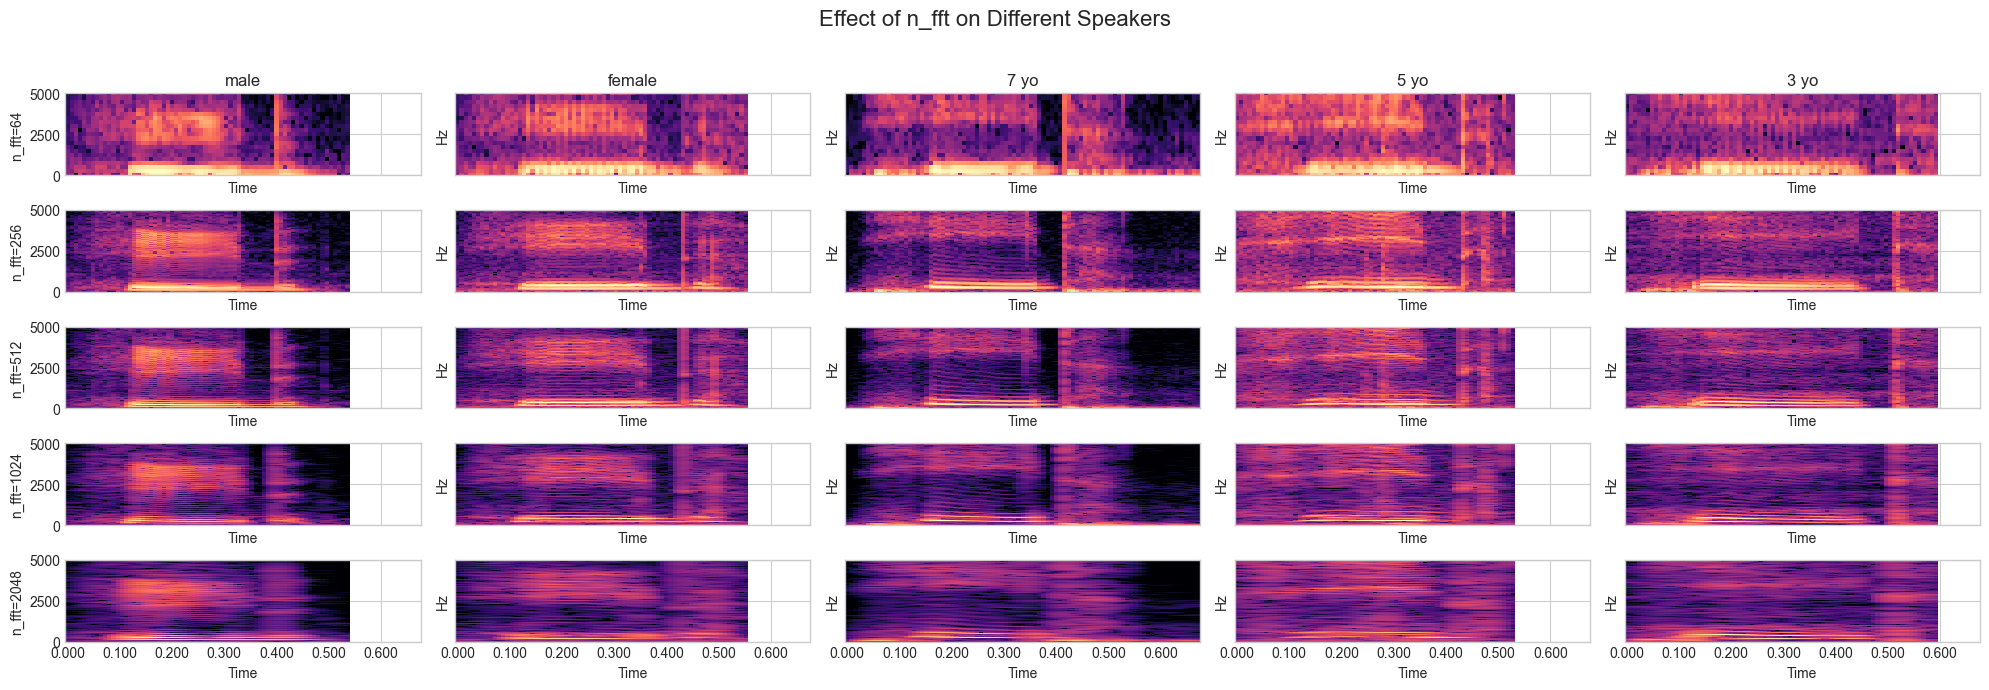

In [20]:
speakers = list(audio_data.keys())
n_fft_values = [64, 256, 512, 1024, 2048]
hop_len_fixed = 128

fig, axes = plt.subplots(nrows=len(n_fft_values), ncols=len(speakers), 
                       figsize=(20, 7), sharex=True, sharey=True)
fig.suptitle('Effect of n_fft on Different Speakers', fontsize=16)

for i, n_fft in enumerate(n_fft_values):
    for j, speaker in enumerate(speakers):
        ax = axes[i, j]
        y = audio_data[speaker]
        S = librosa.stft(y, n_fft=n_fft, hop_length=hop_len_fixed)
        S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        librosa.display.specshow(S_db, sr=sample_rate, hop_length=hop_len_fixed, 
                                 x_axis='time', y_axis='linear', ax=ax)
        ax.set_ylim(0, 5000)
        if i == 0:
            ax.set_title(speaker.replace('_', ' '))
        if j == 0:
            ax.set_ylabel(f'n_fft={n_fft}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations

*   **General Effect**: For all speakers, `n_fft=512` produces a "wideband" spectrogram with clear formant structures but smeared harmonics. In contrast, `n_fft=2048` produces a "narrowband" spectrogram where individual harmonics are sharp and distinct, but the formants are harder to trace over time.

*   **Speaker Comparison**: The harmonics are easier to differentiate for girl children compared to adult man.
This demonstrates that the choice of `n_fft` depends not only on what we want to analyze but also on the characteristics of the signal itself.

### 5.7.2: Varying `hop_length` Across Speakers

Next, we fix `n_fft` and vary the `hop_length` to observe its effect on temporal resolution.

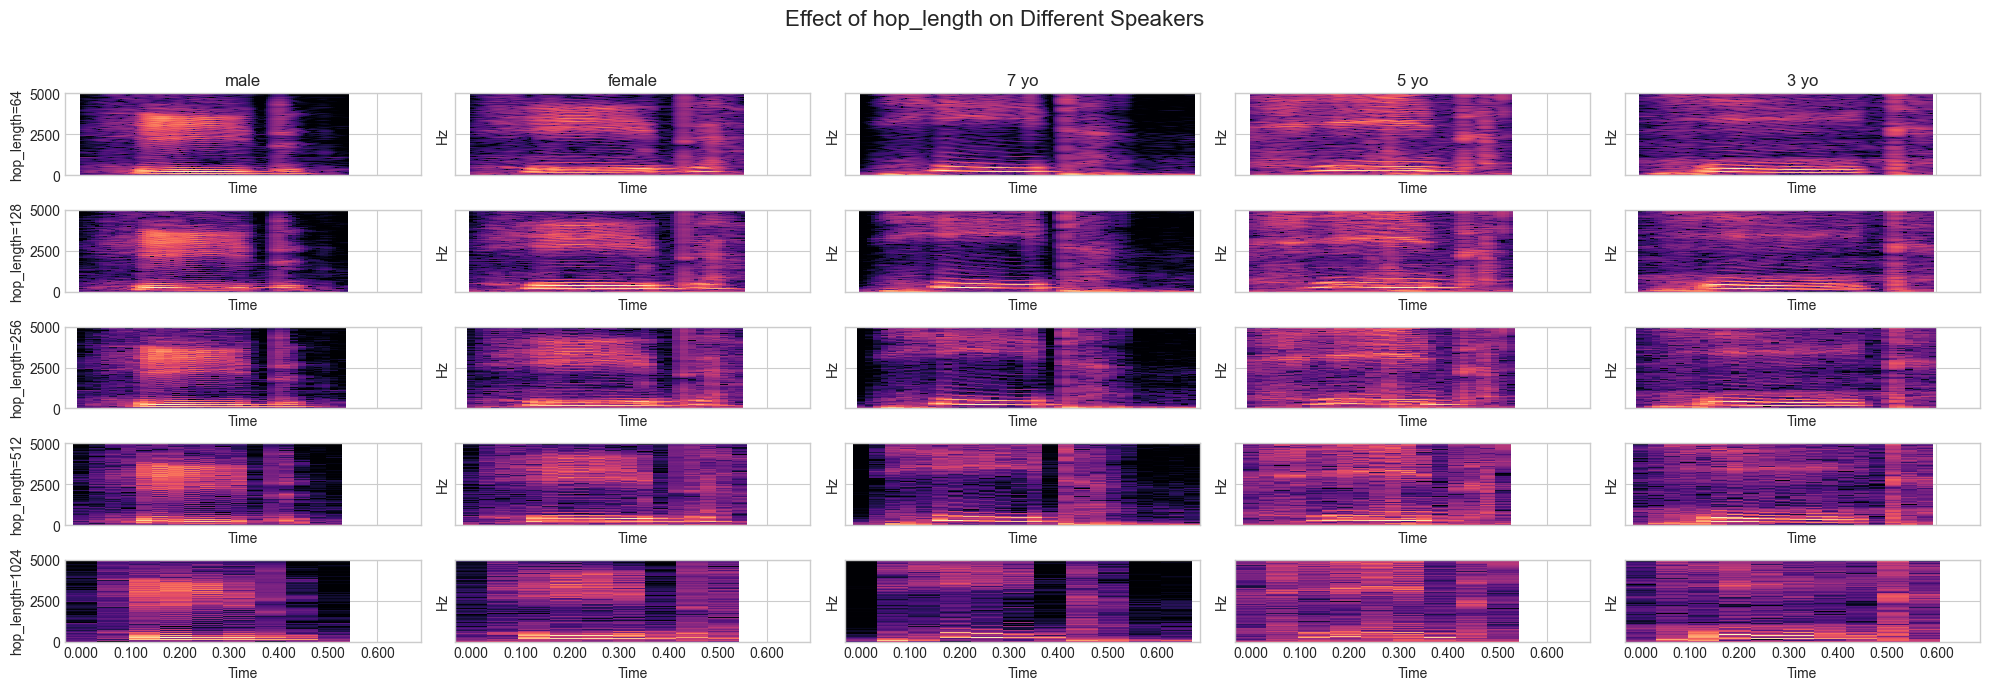

In [21]:
hop_length_values = [64, 128, 256, 512, 1024]
n_fft_fixed = 1024

fig, axes = plt.subplots(nrows=len(hop_length_values), ncols=len(speakers),
                       figsize=(20, 7), sharex=True, sharey=True)
fig.suptitle('Effect of hop_length on Different Speakers', fontsize=16)

for i, hop_length in enumerate(hop_length_values):
    for j, speaker in enumerate(speakers):
        ax = axes[i, j]
        y = audio_data[speaker]
        S = librosa.stft(y, n_fft=n_fft_fixed, hop_length=hop_length)
        S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
        librosa.display.specshow(S_db, sr=sample_rate, hop_length=hop_length, 
                                 x_axis='time', y_axis='linear', ax=ax)
        ax.set_ylim(0, 5000)
        if i == 0:
            ax.set_title(speaker.replace('_', ' '))
        if j == 0:
            ax.set_ylabel(f'hop_length={hop_length}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations

The effect of `hop_length` is consistent across all speakers. A small `hop_length=64` results in a high number of time frames, producing a detailed spectrogram along the time axis. A large `hop_length=512` results in a coarse spectrogram with poor time resolution.

For analyzing the steady-state part of a vowel, a larger hop length might be acceptable. For capturing the rapid transitions between phonemes (e.g., in a consonant-vowel pair), a smaller hop length is essential.

### 5.7.3: Varying `n_mels` Across Speakers

We now compute Mel spectrograms and see how the number of Mel filters (`n_mels`) affects the representation of the spectral envelope for different speakers.

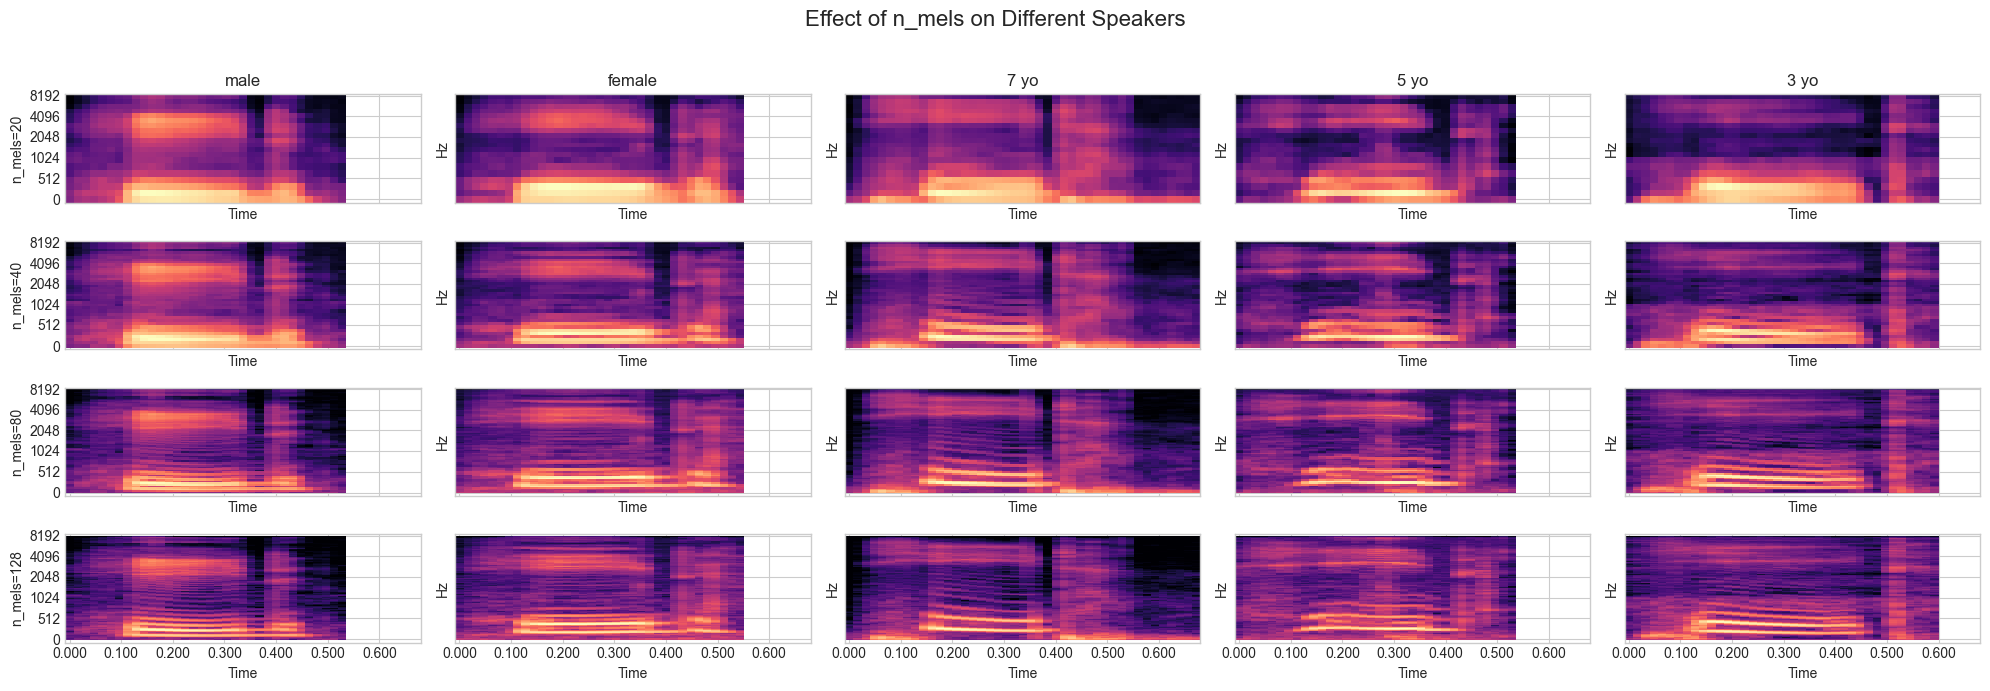

In [22]:
n_mels_values = [20, 40, 80, 128]
n_fft_fixed = 1024
hop_len_fixed = 256

fig, axes = plt.subplots(nrows=len(n_mels_values), ncols=len(speakers),
                       figsize=(20, 7), sharex=True, sharey=True)
fig.suptitle('Effect of n_mels on Different Speakers', fontsize=16)

for i, n_mels in enumerate(n_mels_values):
    for j, speaker in enumerate(speakers):
        ax = axes[i, j]
        y = audio_data[speaker]
        M = librosa.feature.melspectrogram(y=y, sr=sample_rate, n_fft=n_fft_fixed, 
                                         hop_length=hop_len_fixed, n_mels=n_mels)
        M_db = librosa.power_to_db(M, ref=np.max)
        librosa.display.specshow(M_db, sr=sample_rate, hop_length=hop_len_fixed, 
                                 x_axis='time', y_axis='mel', ax=ax)
        if i == 0:
            ax.set_title(speaker.replace('_', ' '))
        if j == 0:
            ax.set_ylabel(f'n_mels={n_mels}')
            
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations

*   **General Effect**: Using `n_mels=20` heavily smooths the spectrum, averaging over the harmonics. With `n_mels=128`, much more spectral detail is preserved, and the locations of the formants can be seen clearly.

*   **Speaker Comparison**: The male speaker's formants are at lower frequencies compared to the female and child speakers. A low `n_mels` still captures these broad differences, but a high `n_mels` is needed to see the finer details that differentiate them.

### 5.7.4: Varying Number of MFCCs Across Speakers

MFCCs provide a compact representation of the spectral envelope. We observe how the coefficients differ across speakers.

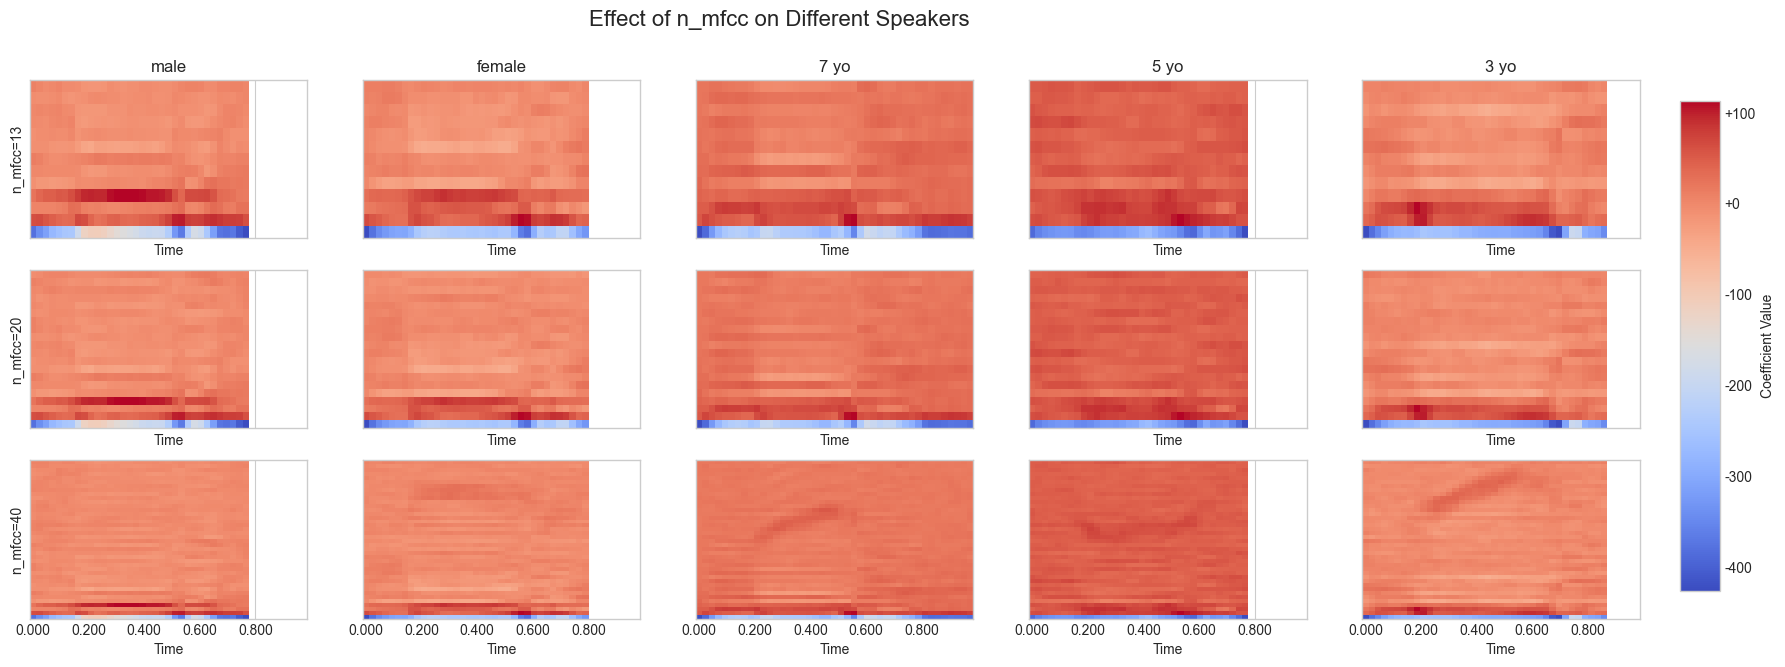

In [29]:
from matplotlib.ticker import MaxNLocator
n_mfcc_values = [13, 20, 40]
n_fft_fixed = 1024
hop_len_fixed = 256

fig, axes = plt.subplots(nrows=len(n_mfcc_values), ncols=len(speakers),
                       figsize=(20, 7), sharex=True)
fig.suptitle('Effect of n_mfcc on Different Speakers', fontsize=16)

for i, n_mfcc in enumerate(n_mfcc_values):
    for j, speaker in enumerate(speakers):
        ax = axes[i, j]
        y = audio_data[speaker]
        mfccs = librosa.feature.mfcc(y=y, sr=sample_rate, n_mfcc=n_mfcc, 
                                     n_fft=n_fft_fixed, hop_length=hop_len_fixed)
        img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5, prune="lower"))
        if i == 0:
            ax.set_title(speaker.replace('_', ' '))
        if j == 0:
            ax.set_ylabel(f'n_mfcc={n_mfcc}')
fig.subplots_adjust(right=0.93)

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])

cbar = fig.colorbar(img, cax=cbar_ax, format="%+2.f")

cbar.set_label("Coefficient Value")

#### Observations

*   **General Effect**: The top rows of the MFCC plots represent the broad spectral features, while the bottom rows represent finer details. 
Since the vowel is relatively stationary, the coefficients are somewhat constant over the middle time range.

*   **Speaker Comparison**: The pattern of the coefficients is somewhat unique for each speaker, even for the same vowel. This is because MFCCs are good at capturing the shape of the vocal tract as well, which is physiologically different for each person. 

Using 40 MFCCs (bottom row) adds more detail, but the primary distinguishing information is already present in the first 13.

### 5.7.5: Applying Pre-emphasis Across Speakers

Finally, we apply a pre-emphasis filter to observe how it balances the spectral tilt for different speakers.

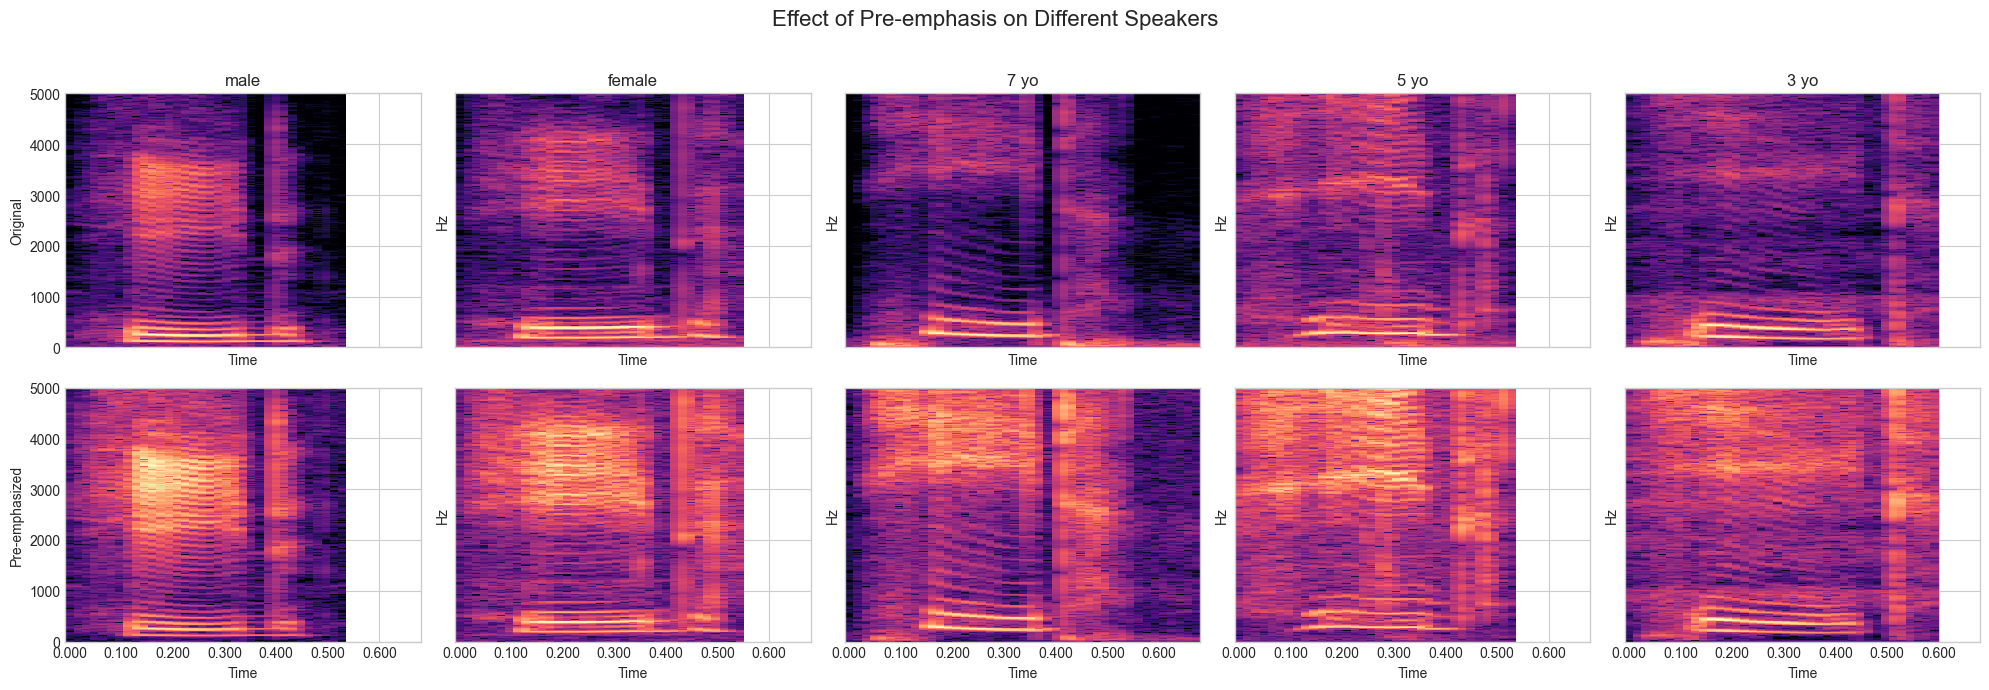

In [24]:
n_fft_fixed = 1024
hop_len_fixed = 256

fig, axes = plt.subplots(nrows=2, ncols=len(speakers),
                       figsize=(20, 7), sharex=True, sharey=True)
fig.suptitle('Effect of Pre-emphasis on Different Speakers', fontsize=16)

for j, speaker in enumerate(speakers):
    y = audio_data[speaker]
    y_pre = librosa.effects.preemphasis(y, coef=0.97)

    # Top row: Original
    ax_orig = axes[0, j]
    S_orig = librosa.stft(y, n_fft=n_fft_fixed, hop_length=hop_len_fixed)
    S_orig_db = librosa.amplitude_to_db(np.abs(S_orig), ref=np.max)
    librosa.display.specshow(S_orig_db, sr=sample_rate, hop_length=hop_len_fixed, 
                             x_axis='time', y_axis='linear', ax=ax_orig)
    ax_orig.set_title(speaker.replace('_', ' '))
    ax_orig.set_ylim(0, 5000)
    if j == 0: ax_orig.set_ylabel('Original')
        
    # Bottom row: Pre-emphasized
    ax_pre = axes[1, j]
    S_pre = librosa.stft(y_pre, n_fft=n_fft_fixed, hop_length=hop_len_fixed)
    S_pre_db = librosa.amplitude_to_db(np.abs(S_pre), ref=np.max)
    librosa.display.specshow(S_pre_db, sr=sample_rate, hop_length=hop_len_fixed, 
                           x_axis='time', y_axis='linear', ax=ax_pre)
    if j == 0: ax_pre.set_ylabel('Pre-emphasized')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

#### Observations

*   **General Effect**: For every speaker, the original spectrogram (top row) shows that most of the energy is concentrated in the low frequencies. 
After pre-emphasis (bottom row), the energy in the higher frequencies is significantly boosted, making the higher formants much more prominent. 
This high-pass filtering effect is consistent across all speech signals.

*   **Speaker Comparison**: The need for pre-emphasis is clear in all cases. 
It effectively flattens the spectrum, preventing the powerful first formant and fundamental frequency from dominating the signal representation. 
This ensures that features extracted later (like MFCCs) are sensitive to information across the entire frequency spectrum, which is vital for robust speech recognition.